In [1]:
# -------------------------------------------
# 1. IMPORT LIBRARIES AND SET PATHS
# -------------------------------------------

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

# Import config paths
import sys
sys.path.append('..')
from config import SUMMARY_DIR, RESULTS_DIR

# Define primary data source and output paths
# NOTE: Accuracy metrics will be sourced from the F1 scores file below,
consolidated_file = SUMMARY_DIR / "consolidated_results_features_14_16_3_loops_each_feature_set.xlsx"
charts_output_dir = RESULTS_DIR / "charts_14_16"

# Path to the F1-score file (for accuracy metrics)
# This file will be used for all accuracy values in this notebook.
f1_scores_file = RESULTS_DIR / "f1_scores_all_models_14_16.xlsx"
print(f"F1-score file path: {f1_scores_file}")

# Ensure output directory exists
charts_output_dir.mkdir(parents=True, exist_ok=True)

# Load the consolidated results (for runtime metrics only)
df_consolidated = pd.read_excel(consolidated_file)

print(f"Loaded consolidated results: {df_consolidated.shape}")
print(f"Source: {consolidated_file}")
print(f"Charts will be saved to: {charts_output_dir}")

F1-score file path: C:\Misc\ml_benchmark\outputs\results\f1_scores_all_models_14_16.xlsx
Loaded consolidated results: (137, 60)
Source: C:\Misc\ml_benchmark\outputs\summary\consolidated_results_features_14_16_3_loops_each_feature_set.xlsx
Charts will be saved to: C:\Misc\ml_benchmark\outputs\results\charts_14_16


In [2]:
# -------------------------------------------
# 2. DEFINE FUNCTION TO EXPORT PLOTS TO PDF AND PNG
# -------------------------------------------

# Horizontal bar chart with accuracy and runtime performance

# Define a function to create and save a PDF and a PNG file of any chart created just prior to this function's call.

def export_plot(fig, model_set_name="default", export_dir=charts_output_dir, dpi=600):
    """
    Save a matplotlib figure as both PDF and high-resolution PNG using the model set name.

    Parameters:
        fig (matplotlib.figure.Figure): The plot to save
        model_set_name (str): Descriptive label (used in filename, e.g., 'features_14_16')
        export_dir (str): Folder path where files will be saved
        dpi (int): Dots per inch (applies to PNG only)
    """
    import os
    # Ensure export directory exists
    os.makedirs(export_dir, exist_ok=True)
    
    base_filename = f"{export_dir}/acc_time_{model_set_name}"
    
    # Save as PDF (vector format). Change the white space padding with pad_inches
    fig.savefig(f"{base_filename}.pdf", format="pdf", bbox_inches="tight", pad_inches=0.6)

    # Save as PNG (high-res raster)
    fig.savefig(f"{base_filename}.png", format="png", dpi=dpi, bbox_inches="tight")

    print(f"✔️ Chart exported as:\n - {base_filename}.pdf\n - {base_filename}.png")

In [3]:
# -------------------------------------------
# 3. PREPARE ACCURACY AND RUNTIME DATAFRAME
# -------------------------------------------

# Load F1 scores file (for accuracy)

# Read all sheets and concatenate into one DataFrame
all_sheets = pd.read_excel(f1_scores_file, sheet_name=None)
df_f1 = pd.concat(all_sheets.values(), ignore_index=True)
print(df_f1['Model'].unique())
print()

print(f"Loaded F1 scores (num models, num fields per model): {df_f1.shape}")
print()

# Inspect columns for both files
consolidated_cols = df_consolidated.columns.tolist()
for i in range(0, len(consolidated_cols), 5):
    print(" | ".join(consolidated_cols[i:i+5]))

print("F1 scores columns:", df_f1.columns.tolist())

# --- Extract mean runtime for each model from consolidated results ---
runtime_to_longname = {
    "decisiontree": "DecisionTreeClassifier",
    "randomforest": "RandomForestClassifier",
    "extratrees": "ExtraTreesClassifier",
    "gradientboosting": "GradientBoostingClassifier",
    "adaboost": "AdaBoostClassifier",  # <-- FIXED HERE
    "xgb": "XGBClassifier",
    "logisticregression": "LogisticRegression",
    "ridge": "RidgeClassifier",
    "sgd": "SGDClassifier",
    "perceptron": "Perceptron",
    "kneighbors": "KNeighborsClassifier",
    "svc": "SVC",
    "gaussiannb": "GaussianNB",
    "lineardiscriminantanalysis": "LinearDiscriminantAnalysis",
    "quadraticdiscriminantanalysis": "QuadraticDiscriminantAnalysis",
    "mlp": "MLPClassifier"
}
runtime_cols = [col for col in df_consolidated.columns if col.startswith("Runtime_")]
runtime_data = []
for col in runtime_cols:
    short_model = col.replace("Runtime_", "")
    long_model = runtime_to_longname.get(short_model)
    mean_runtime = df_consolidated[col].mean()
    runtime_data.append({"Model": long_model, "mean_runtime_ms": mean_runtime})
df_runtime = pd.DataFrame(runtime_data)

# --- Extract mean Overall_Accuracy for each model from F1 scores file ---
if "Model" not in df_f1.columns or "Overall_Accuracy" not in df_f1.columns:
    raise ValueError("F1 scores file must have columns 'Model' and 'Overall_Accuracy'.")

df_acc = (
    df_f1.groupby("Model", as_index=False)["Overall_Accuracy"]
    .mean()
    .rename(columns={"Overall_Accuracy": "mean_accuracy"})
)

# --- Merge runtime and accuracy on long model names ---
df_perf = pd.merge(df_runtime, df_acc, on="Model", how="inner")
print("Merged performance data:")
print(df_perf.head())

# --- Map model names to display labels (using long names as keys) ---
model_label_map = {
    "DecisionTreeClassifier": "Decision Tree",
    "RandomForestClassifier": "Random Forest",
    "ExtraTreesClassifier": "Extra Trees",
    "GradientBoostingClassifier": "Gradient Boosting",
    "AdaBoostClassifier": "AdaBoost",
    "XGBClassifier": "XGB Classifier",
    "LogisticRegression": "Logistic Regression",
    "RidgeClassifier": "Ridge Classifier",
    "SGDClassifier": "SGD Classifier",
    "Perceptron": "Perceptron",
    "KNeighborsClassifier": "KNeighbors Classifier",
    "SVC": "SVC",
    "GaussianNB": "Gaussian NB",
    "LinearDiscriminantAnalysis": "Linear Discriminant Analysis",
    "QuadraticDiscriminantAnalysis": "Quadratic Discriminant Analysis",
    "MLPClassifier": "MLP Classifier"
}
df_perf["ModelLabel"] = df_perf["Model"].map(model_label_map).fillna(df_perf["Model"])

# --- Display results to confirm the dataframe is populated correctly ---
print("\nFinal accuracy and runtime table:")
display(df_perf[["ModelLabel", "mean_accuracy", "mean_runtime_ms"]].rename(
    columns={
        "ModelLabel": "Model",
        "mean_accuracy": "Mean Overall Accuracy",
        "mean_runtime_ms": "Mean Runtime (ms)"
    }
).set_index("Model"))


print(df_perf.head())

df_perf.head()

print("df_runtime['Model'] unique values:", df_runtime['Model'].unique())
print("df_acc['Model'] unique values:", df_acc['Model'].unique())



['AdaBoostClassifier' 'DecisionTreeClassifier' 'ExtraTreesClassifier'
 'GaussianNB' 'GradientBoostingClassifier' 'KNeighborsClassifier'
 'LinearDiscriminantAnalysis' 'LogisticRegression' 'MLPClassifier'
 'Perceptron' 'QuadraticDiscriminantAnalysis' 'RandomForestClassifier'
 'RidgeClassifier' 'SGDClassifier' 'SVC' 'XGBClassifier']

Loaded F1 scores (num models, num fields per model): (16, 4)

Feature_1 | Feature_2 | Feature_3 | Feature_4 | Feature_5
Feature_6 | Feature_7 | Feature_8 | Feature_9 | Feature_10
Feature_11 | Feature_12 | Feature_13 | Feature_14 | Feature_15
Feature_16 | Accuracy_adaboost | Runtime_adaboost | Accuracy_decisiontree | Runtime_decisiontree
Accuracy_extratrees | Runtime_extratrees | Accuracy_gaussiannb | Runtime_gaussiannb | Accuracy_gradientboosting
Runtime_gradientboosting | Accuracy_kneighbors | Runtime_kneighbors | Accuracy_lineardiscriminantanalysis | Runtime_lineardiscriminantanalysis
Accuracy_logisticregression | Runtime_logisticregression | Accuracy_mlp |

,Mean Overall Accuracy,Mean Runtime (ms)
Model,,
AdaBoost,0.8441,7932.670774
Decision Tree,0.9081,559.553073
Extra Trees,0.9229,594.101000
Gaussian NB,0.8967,20.094219
Gradient Boosting,0.9269,26160.033431
KNeighbors Classifier,0.9250,266.418029
Linear Discriminant Analysis,0.9046,37.095693
Logistic Regression,0.9243,1254.122591
MLP Classifier,0.9338,12355.129569


                        Model  mean_runtime_ms  mean_accuracy  \
0          AdaBoostClassifier      7932.670774         0.8441   
1      DecisionTreeClassifier       559.553073         0.9081   
2        ExtraTreesClassifier       594.101000         0.9229   
3                  GaussianNB        20.094219         0.8967   
4  GradientBoostingClassifier     26160.033431         0.9269   

          ModelLabel  
0           AdaBoost  
1      Decision Tree  
2        Extra Trees  
3        Gaussian NB  
4  Gradient Boosting  
df_runtime['Model'] unique values: ['AdaBoostClassifier' 'DecisionTreeClassifier' 'ExtraTreesClassifier'
 'GaussianNB' 'GradientBoostingClassifier' 'KNeighborsClassifier'
 'LinearDiscriminantAnalysis' 'LogisticRegression' 'MLPClassifier'
 'Perceptron' 'QuadraticDiscriminantAnalysis' 'RandomForestClassifier'
 'RidgeClassifier' 'SGDClassifier' 'SVC' 'XGBClassifier']
df_acc['Model'] unique values: ['AdaBoostClassifier' 'DecisionTreeClassifier' 'ExtraTreesClassifier'
 'G

df_perf shape: (16, 4)
                        Model  mean_runtime_ms  mean_accuracy  \
0          AdaBoostClassifier      7932.670774         0.8441   
1      DecisionTreeClassifier       559.553073         0.9081   
2        ExtraTreesClassifier       594.101000         0.9229   
3                  GaussianNB        20.094219         0.8967   
4  GradientBoostingClassifier     26160.033431         0.9269   

          ModelLabel  
0           AdaBoost  
1      Decision Tree  
2        Extra Trees  
3        Gaussian NB  
4  Gradient Boosting  
                            Model  order
0          DecisionTreeClassifier      1
1          RandomForestClassifier      2
2            ExtraTreesClassifier      3
3      GradientBoostingClassifier      4
4              AdaBoostClassifier      5
5                   XGBClassifier      6
6              LogisticRegression      7
7                 RidgeClassifier      8
8                   SGDClassifier      9
9                      Perceptron     

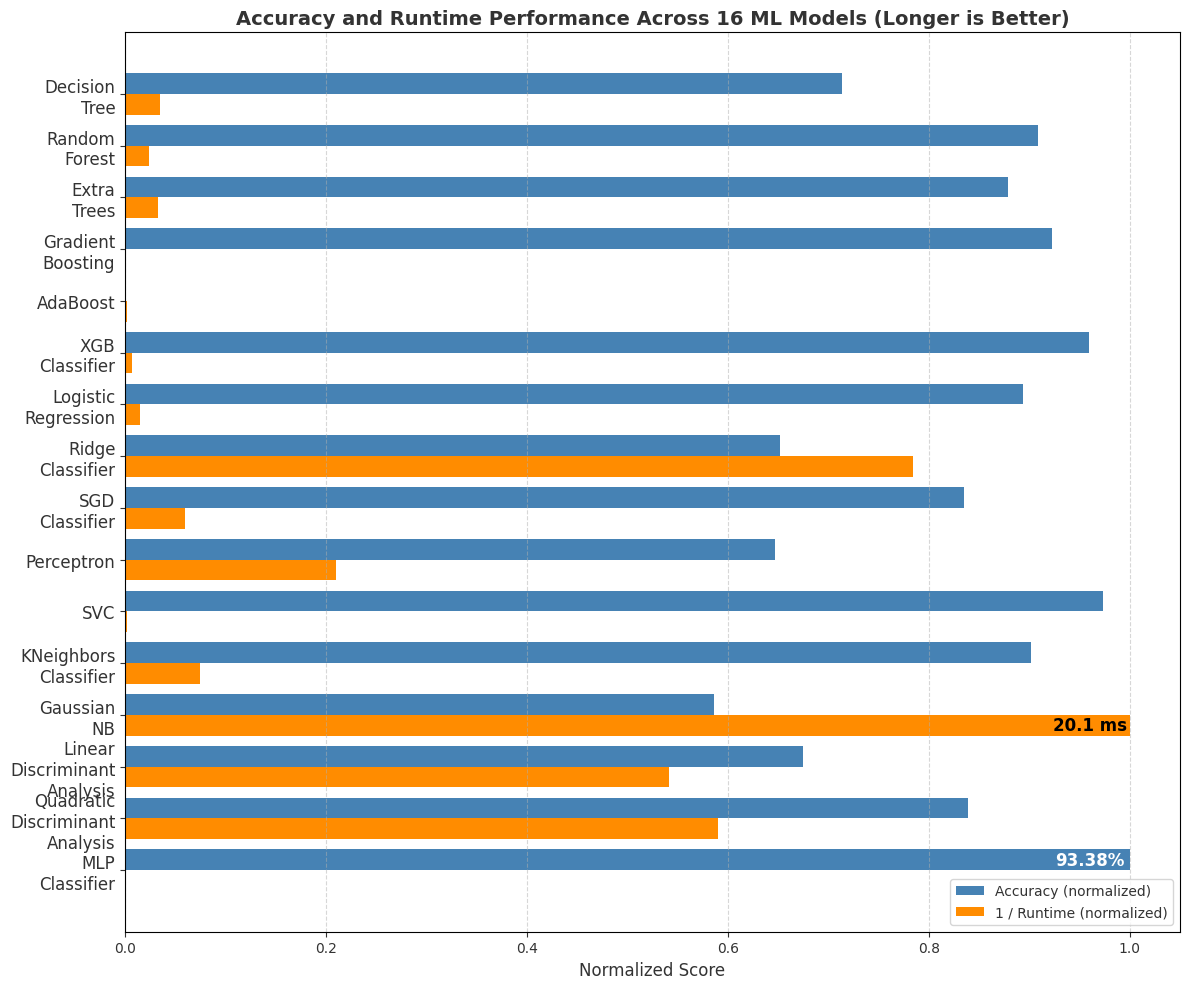


Grouped Bar Chart Data (Accuracy and Inverted Normalized Runtime):


,Mean Overall Accuracy,Normalized Accuracy,Mean Runtime (ms),Inverted Normalized Runtime
Model,,,,
Decision Tree,0.9081,0.713489,559.553073,0.035170
Random Forest,0.9256,0.908584,820.765978,0.023732
Extra Trees,0.9229,0.878484,594.101000,0.033080
Gradient Boosting,0.9269,0.923077,26160.033431,0.000000
AdaBoost,0.8441,0.000000,7932.670774,0.001766
XGB Classifier,0.9302,0.959866,2546.487343,0.007128
Logistic Regression,0.9243,0.894091,1254.122591,0.015266
Ridge Classifier,0.9026,0.652174,25.610190,0.784453
SGD Classifier,0.9190,0.835006,330.601336,0.060059


In [8]:
# -------------------------------------------
# 4. PREPARE ACCURACY AND RUNTIME GROUPED BAR CHART (using df_perf only)
# -------------------------------------------

print("df_perf shape:", df_perf.shape)
print(df_perf.head())


# Use only the merged DataFrame df_perf for plotting
df = df_perf.copy()

# Helper: wrap display names at spaces for better y-axis readability
def wrap_label(name, max_words_per_line=1, max_lines=3):
    words = name.split()
    chunks = [
        ' '.join(words[i:i + max_words_per_line])
        for i in range(0, len(words), max_words_per_line)
    ]
    return '\n'.join(chunks[:max_lines])

# Apply wrapped axis labels
df["WrappedLabel"] = df["ModelLabel"].apply(lambda x: wrap_label(x, max_words_per_line=1))

# Define consistent model ordering by family

model_family_order = {
    # Tree-based Models
    "decisiontreeclassifier": 1,
    "randomforestclassifier": 2,
    "extratreesclassifier": 3,
    "gradientboostingclassifier": 4,
    "adaboostclassifier": 5,
    "xgbclassifier": 6,
    # Linear Models
    "logisticregression": 7,
    "ridgeclassifier": 8,
    "sgdclassifier": 9,
    "perceptron": 10,
    # Kernel-based Model
    "svc": 11,
    # Instance-based Models
    "kneighborsclassifier": 12,
    # Probabilistic Models
    "gaussiannb": 13,
    # Discriminant Models
    "lineardiscriminantanalysis": 14,
    "quadraticdiscriminantanalysis": 15,
    # Neural Models
    "mlpclassifier": 16
}

# Add ordering column, then sort
# "Model" is the canonical (aka, long) model name used for merging accuracy and 
# runtime data from two different Excel file sources.  Needs go be lower case so it
# matches the keys in model_family_order, which are all lowercase.
df["order"] = df["Model"].str.lower().map(model_family_order)  
df = df.sort_values('order').reset_index(drop=True)

# Normalize metrics
df["norm_accuracy"] = (df["mean_accuracy"] - df["mean_accuracy"].min()) / (df["mean_accuracy"].max() - df["mean_accuracy"].min())
df["inv_runtime"] = 1 / df["mean_runtime_ms"]
df["norm_inv_runtime"] = (df["inv_runtime"] - df["inv_runtime"].min()) / (df["inv_runtime"].max() - df["inv_runtime"].min())

# DEBUGGING CODE ONLY
print(df[["Model", "order"]])
print(df)



# Identify highest-accuracy and best-runtime models (need to find new indices after sorting)
max_acc_idx = df["mean_accuracy"].idxmax()
min_rt_idx = df["mean_runtime_ms"].idxmin()

# Plot setup
y_pos = np.arange(len(df))
bar_height = 0.4

fig, ax = plt.subplots(figsize=(12, 10))  # Taller figure for vertical model list

# Horizontal accuracy bars
bars_acc = ax.barh(y_pos - bar_height/2, df["norm_accuracy"], height=bar_height,
                   label="Accuracy (normalized)", color="steelblue")

# Horizontal runtime bars
bars_rt = ax.barh(y_pos + bar_height/2, df["norm_inv_runtime"], height=bar_height,
                  label="1 / Runtime (normalized)", color="darkorange")

# Add value labels inside bars (horizontal text)
acc_label = f"{df.loc[max_acc_idx, 'mean_accuracy']:.2%}"
rt_label = f"{df.loc[min_rt_idx, 'mean_runtime_ms']:.1f} ms"

# Position accuracy label (horizontal text inside blue bar)
ax.text(
    df.loc[max_acc_idx, "norm_accuracy"] * 0.96,  # At right edge of bar
    y_pos[max_acc_idx] - bar_height/2,
    acc_label,
    ha="center",
    va="center",
    fontsize=12,
    color="white",
    fontweight="bold"
)

# Position runtime label (horizontal text inside orange bar)
ax.text(
    df.loc[min_rt_idx, "norm_inv_runtime"] * 0.96,  # Middle of bar
    y_pos[min_rt_idx] + bar_height/2,
    rt_label,
    ha="center",
    va="center",
    fontsize=12,
    color="black",
    fontweight="bold"
)

# Axis labels and formatting
axis_font_color = "#333333"
ax.set_yticks(y_pos)
ax.set_yticklabels(df["WrappedLabel"], fontsize=10, color=axis_font_color)  # Use wrapped labels to allow more space for chart
ax.set_xlabel("Normalized Score", fontsize=12, color=axis_font_color)
ax.set_title("Accuracy and Runtime Performance Across 16 ML Models (Longer is Better)", 
             fontsize=14, weight="bold", color=axis_font_color)
ax.legend(loc='lower right', labelcolor=axis_font_color)
ax.grid(axis="x", linestyle="--", alpha=0.5)
ax.tick_params(axis='x', labelsize=10, colors=axis_font_color)   # x-axis tick labels
ax.tick_params(axis='y', labelsize=12, colors=axis_font_color)   # y-axis tick labels

# Invert y-axis to show first model at top
ax.invert_yaxis()

plt.tight_layout()
plt.show()

# Display the accuracy and inverted normalized runtime for each model used in the grouped bar chart
print("\nGrouped Bar Chart Data (Accuracy and Inverted Normalized Runtime):")
print("="*60)
display(df[["ModelLabel", "mean_accuracy", "norm_accuracy", "mean_runtime_ms", "norm_inv_runtime"]].rename(
    columns={
        "ModelLabel": "Model",
        "mean_accuracy": "Mean Overall Accuracy",
        "norm_accuracy": "Normalized Accuracy",
        "mean_runtime_ms": "Mean Runtime (ms)",
        "norm_inv_runtime": "Inverted Normalized Runtime"
    }
).set_index("Model"))
print("="*60)

In [ ]:
# -------------------------------------------
# 5. CREATE AND SAVE THE CHART
# -------------------------------------------

# Create a PDF and PNG of the chart just created in prior cell.
export_plot(fig, model_set_name="grouped_bar_14_16_3_loops_each_feature_set")

✔️ Chart exported as:
 - C:\Misc\ml_benchmark\outputs\results\charts_14_16/acc_time_grouped_bar_14_16_3_loops_each_feature_set.pdf
 - C:\Misc\ml_benchmark\outputs\results\charts_14_16/acc_time_grouped_bar_14_16_3_loops_each_feature_set.png


Original runtime range: 19.3 - 33474.4 ms
Normalized runtime range: 0.000 - 1.000


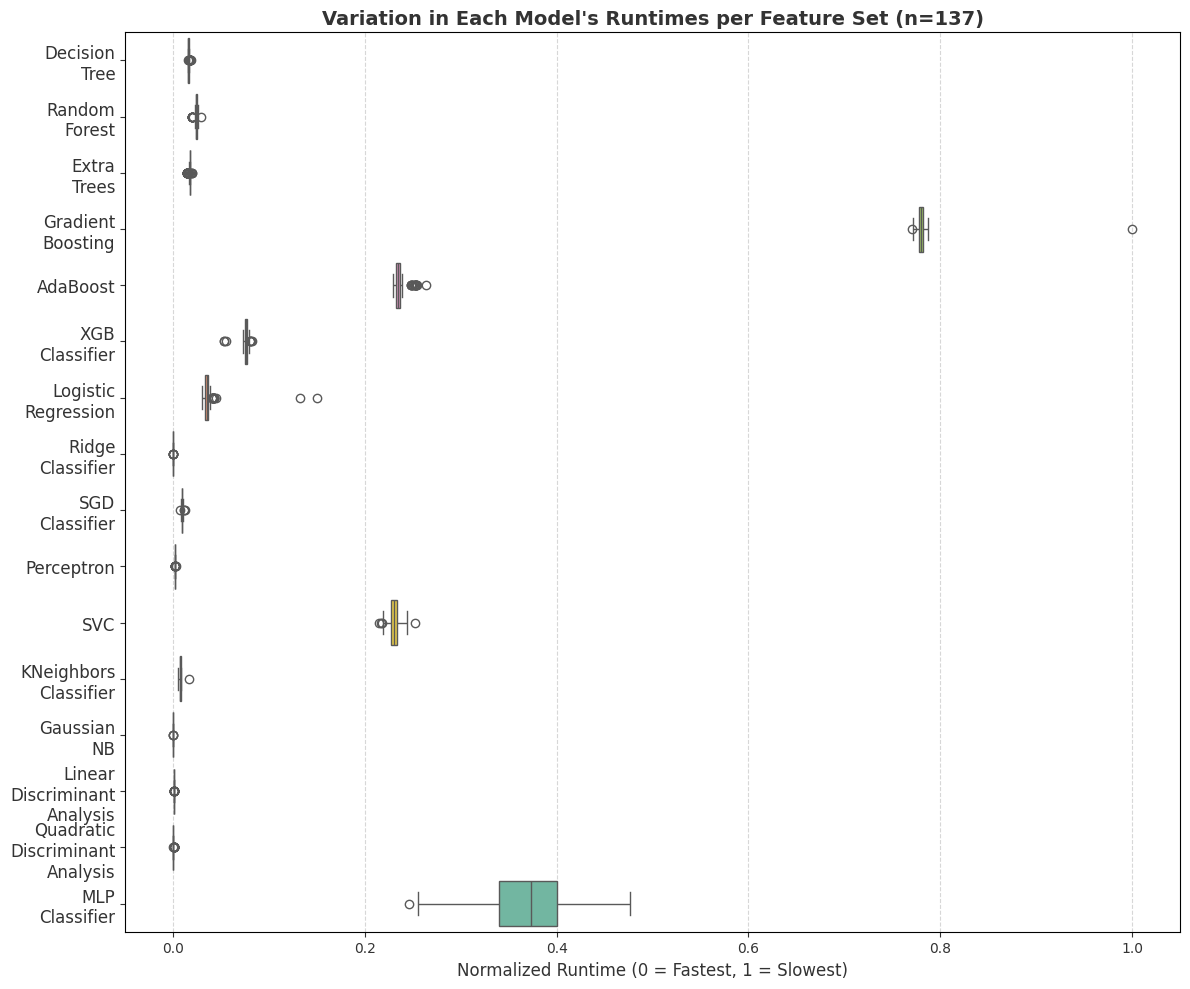

,ModelLabel,Mean_Runtime_ms,Q1,Q3,IQR
8,MLP Classifier,12355.129569,0.339888,0.400573,0.060685
14,SVC,7728.767226,0.227448,0.233968,0.006520
0,AdaBoost,7932.670774,0.232972,0.237159,0.004188
4,Gradient Boosting,26160.033431,0.778005,0.782080,0.004075
7,Logistic Regression,1254.122591,0.033839,0.036431,0.002593
15,XGB Classifier,2546.487343,0.074744,0.076766,0.002023
5,KNeighbors Classifier,266.418029,0.006817,0.007929,0.001112
11,Random Forest,820.765978,0.023728,0.024727,0.000999
13,SGD Classifier,330.601336,0.008832,0.009728,0.000896
2,Extra Trees,594.101000,0.017291,0.017575,0.000284


Here is the df dataframe


NameError: name 'df' is not defined

In [5]:
# -------------------------------------------
# 6. CREATE BOX PLOT OF RUNTIME DATA
# -------------------------------------------

# Box Plot of Runtime Distributions Across Models (models on y-axis)
# Uses real data from consolidated Excel file with normalized runtime values

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the consolidated results (reuse from earlier)
# df_consolidated is already loaded from a prior cell

# Extract all runtime data for each model
runtime_cols = [col for col in df_consolidated.columns if col.startswith("Runtime_")]

# Build long-format data for box plot
runtime_data = []
for runtime_col in runtime_cols:
    model_name = runtime_col.replace("Runtime_", "")
    
    # Get all runtime values for this model (across all feature sets)
    runtimes = df_consolidated[runtime_col].dropna().tolist()
    
    for runtime_ms in runtimes:
        runtime_data.append({
            "model": model_name,
            "runtime_ms": runtime_ms
        })

# Create DataFrame
df_box = pd.DataFrame(runtime_data)

# Map model names to display labels (reuse from earlier)
model_label_map = {
    "decisiontree": "Decision Tree",
    "randomforest": "Random Forest", 
    "extratrees": "Extra Trees",
    "gradientboosting": "Gradient Boosting",
    "adaboost": "AdaBoost",
    "xgb": "XGB Classifier",
    "logisticregression": "Logistic Regression",
    "ridge": "Ridge Classifier",
    "sgd": "SGD Classifier",
    "perceptron": "Perceptron",
    "kneighbors": "KNeighbors Classifier",
    "svc": "SVC",
    "gaussiannb": "Gaussian NB",
    "lineardiscriminantanalysis": "Linear Discriminant Analysis",
    "quadraticdiscriminantanalysis": "Quadratic Discriminant Analysis",
    "mlp": "MLP Classifier"
}

# Apply display labels
df_box["ModelLabel"] = df_box["model"].map(model_label_map)

# Wrap labels for better y-axis display
def wrap_label(name, max_words_per_line=1, max_lines=3):
    words = name.split()
    chunks = [
        ' '.join(words[i:i + max_words_per_line])
        for i in range(0, len(words), max_words_per_line)
    ]
    return '\n'.join(chunks[:max_lines])

df_box["WrappedLabel"] = df_box["ModelLabel"].apply(lambda x: wrap_label(x, max_words_per_line=1))


# Define model ordering by family consistent with this project's planned grouping an ordering.
# The keys in model_family_order must match the short model names found in df_box["model"].
# This is because df_box was constructed by extracting the model name from each column in df_consolidated
# (e.g., "Runtime_decisiontree" column header became "decisiontree"), so the "model" column 
# now contains these short names. If long names (like "decisiontreeclassifier") were instead 
# used as keys, the mapping would fail and "order" will be NaN.

model_family_order = {
    # Tree-based Models
    "decisiontree": 1,
    "randomforest": 2,
    "extratrees": 3,
    "gradientboosting": 4,
    "adaboost": 5,
    "xgb": 6,
    # Linear Models
    "logisticregression": 7,
    "ridge": 8,
    "sgd": 9,
    "perceptron": 10,
    # Kernel-based Model
    "svc": 11,
    # Instance-based Models
    "kneighbors": 12,
    # Probabilistic Models
    "gaussiannb": 13,
    # Discriminant Models
    "lineardiscriminantanalysis": 14,
    "quadraticdiscriminantanalysis": 15,
    # Neural Models
    "mlp": 16
}

# Add ordering column for consistent sorting
df_box["order"] = df_box["model"].map(model_family_order)

# --- Selectable Normalization Scheme ---
# The longest runtime is 1,300 times the slowest runtime, so must normalize. 
# This function allows passing the aproach. The result will be used in the box chart's x-axis.
def normalize_runtime(data, method="minmax"):
    """
    Normalize runtime data using different methods
    
    Parameters:
        data (pd.Series): Runtime values in milliseconds
        method (str): Normalization method
            - "minmax": Min-Max normalization (0-1)
            - "log": Log transformation
            - "zscore": Z-score normalization
            - "percentile": Percentile ranking (0-100)
    
    Returns:
        pd.Series: Normalized runtime values
    """
    if method == "minmax":
        min_val = data.min()
        max_val = data.max()
        return (data - min_val) / (max_val - min_val)
    
    elif method == "log":
        return np.log(data + 1)  # Add 1 to avoid log(0)
    
    elif method == "zscore":
        return (data - data.mean()) / data.std()
    
    elif method == "percentile":
        return data.rank(pct=True) * 100
    
    else:
        raise ValueError(f"Unknown normalization method: {method}")

# -----------------Choose normalization method here -----------------------
NORMALIZATION_METHOD = "minmax"  # Change this to switch methods

# Apply normalization
df_box["normalized_runtime"] = normalize_runtime(df_box["runtime_ms"], method=NORMALIZATION_METHOD)

# Set up axis labels based on normalization method
if NORMALIZATION_METHOD == "minmax":
    x_label = "Normalized Runtime (0 = Fastest, 1 = Slowest)"
elif NORMALIZATION_METHOD == "log":
    x_label = "Log Runtime (ms)"
elif NORMALIZATION_METHOD == "zscore":
    x_label = "Runtime Z-Score (Standard Deviations from Mean)"
elif NORMALIZATION_METHOD == "percentile":
    x_label = "Runtime Percentile (0-100)"

# Print data range info
print(f"Original runtime range: {df_box['runtime_ms'].min():.1f} - {df_box['runtime_ms'].max():.1f} ms")
print(f"Normalized runtime range: {df_box['normalized_runtime'].min():.3f} - {df_box['normalized_runtime'].max():.3f}")


# Create horizontal box plot
fig, ax = plt.subplots(figsize=(12, 10))

# Create ordered list of models for consistent y-axis ordering
model_order = df_box.groupby('model')['order'].first().sort_values().index.tolist()
wrapped_labels = [df_box[df_box['model'] == model]['WrappedLabel'].iloc[0] for model in model_order]

# Need to reverse the stated the order (e.g., so DecisionTreeClassifier appears at the top).
# Why? Because seaborn's boxplot dislays them from the bottom up by default.
wrapped_labels = wrapped_labels[::-1]  # This reverses the list

# Create a box plot, with ML models ordered on the y-axis as requested.
sns.boxplot(
    data=df_box,
    y="WrappedLabel",
    x="normalized_runtime",
    order=wrapped_labels,  # Use consistent ordering for entire ml_benchmark pipeline.
    palette="Set2",
    orient="h",
    ax=ax
)

# Do some styling.
axis_font_color = "#333333"
ax.set_xlabel(x_label, fontsize=12, color=axis_font_color)
ax.set_ylabel("", fontsize=12, color=axis_font_color)  # Need empty string to block seaborn's default y-label
ax.set_title("Variation in Each Model's Runtimes per Feature Set (n=137)", fontsize=14, weight="bold", color=axis_font_color)
ax.grid(axis="x", linestyle="--", alpha=0.5)
ax.tick_params(axis='x', labelsize=10, colors=axis_font_color)
ax.tick_params(axis='y', labelsize=12, colors=axis_font_color)

# Invert y-axis to show first model family at top
ax.invert_yaxis()

plt.tight_layout()
plt.show()


# Calculate IQR (box width) for each model
iqr_table = (
    df_box.groupby("model")["normalized_runtime"]
    .agg(Q1=lambda x: x.quantile(0.25), Q3=lambda x: x.quantile(0.75))
    .assign(IQR=lambda df: df["Q3"] - df["Q1"])
    .reset_index()
)


# Calculate IQR table (keep 'model' column)
iqr_table = (
    df_box.groupby("model")["normalized_runtime"]
    .agg(Q1=lambda x: x.quantile(0.25), Q3=lambda x: x.quantile(0.75))
    .assign(IQR=lambda df: df["Q3"] - df["Q1"])
    .reset_index()
)

# Merge in the mean runtime
mean_runtime = df_box.groupby("model")["runtime_ms"].mean().reset_index(name="Mean_Runtime_ms")
iqr_table = iqr_table.merge(mean_runtime, on="model", how="left")

# Add display labels
iqr_table["ModelLabel"] = iqr_table["model"].map(model_label_map)

# Reorder columns: ModelLabel, Mean_Runtime_ms, Q1, Q3, IQR
iqr_table = iqr_table[["ModelLabel", "Mean_Runtime_ms", "Q1", "Q3", "IQR"]]

# Display the table
display(iqr_table.sort_values("IQR", ascending=False))


print("Here is the df dataframe")
print(df)


In [48]:

# -------------------------------------------
# 6. CREATE AND SAVE THE CHART
# -------------------------------------------

# Create a PDF and PNG of the chart just created in prior cell.
export_plot(fig, model_set_name="box_chart_time_14_16_3_loops_each_feature_set")

✔️ Chart exported as:
 - C:\Misc\ml_benchmark\outputs\results\charts_14_16/acc_time_box_chart_time_14_16_3_loops_each_feature_set.pdf
 - C:\Misc\ml_benchmark\outputs\results\charts_14_16/acc_time_box_chart_time_14_16_3_loops_each_feature_set.png


   model  accuracy  inv_norm_runtime
0     DT    0.9081          6.786785
1     RF    0.9256          4.626857
2     ET    0.9229          6.392123
3     GB    0.9269          0.145167
4     AB    0.8441          0.478725
5    XGB    0.9302          1.491296
6     LR    0.9243          3.028066
7     RC    0.9026        148.283417
8    SGD    0.9190         11.486845
9     PC    0.9021         39.740706
10   SVC    0.9314          0.491355
11   KNN    0.9250         14.254165
12   GNB    0.8967        188.988010
13   LDA    0.9046        102.372165
14   QDA    0.9194        111.515563
15   MLP    0.9338          0.307368


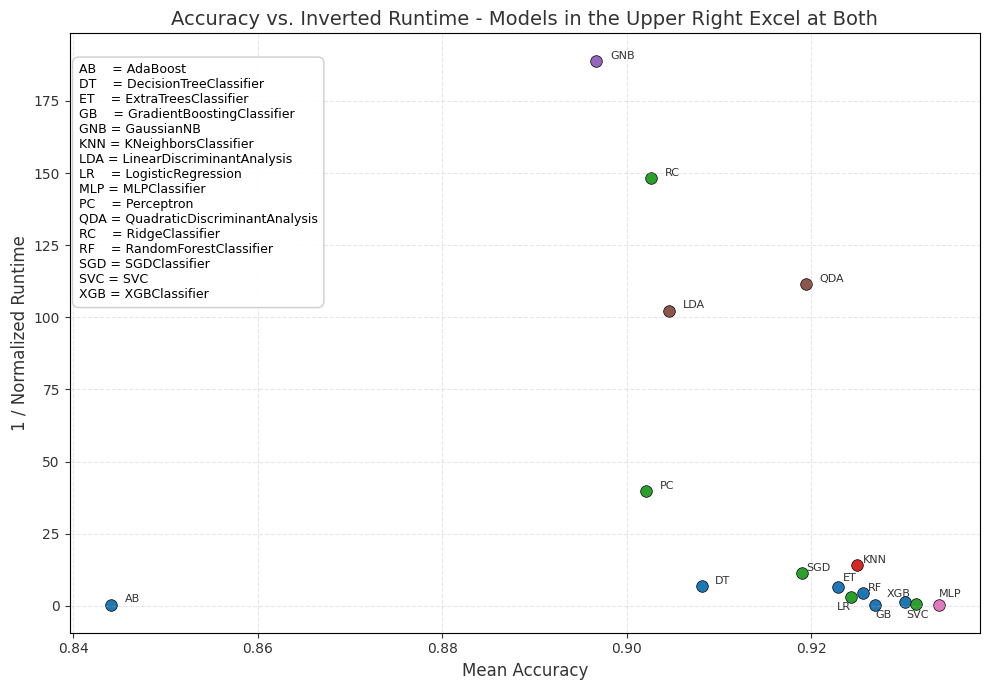

In [ ]:
# -------------------------------------------
# 7. PREPARE TRADEOFF CHART - ACCURACY VS. RUNTIME
# -------------------------------------------


# SCATTER CHART OF ACCURACY vs. INVERTED NORMALIZED RUNTIME


import pandas as pd
import matplotlib.pyplot as plt

# # Set up for config (placeholder – replace with config.py) ---
# excel_path = r"C:\Misc\ml_benchmark\outputs\summary\consolidated_results_features_14_16_3_loops_each_feature_set.xlsx"

# Use the already-prepared df DataFrame from earlier cells
plot_df = df.copy()

# Set up the chart format
axis_font_color = "#333333"
dot_size = 70
label_fontsize = 8
label_offset_x = 0.0015  # horizontal nudge for labels
label_offset_y = 0.02    # vertical nudge for labels

# Some dots for models may overlap, blocking the dots' labels
# Overlap occurs when models have very similar accuracy and runtime values.
# To resolve, use some custom nudges to tweak label placement
custom_offsets = {
    "SVC": (-0.0011, -5.50),
    "XGB": (-0.002, 1.0),
    "MLP": (-0.00, 2.0),
    "GB":  (0.0, -5.0),
    "ET":  (0.0005, 1.5),
    "RF":  (0.0005, 0.00),
    "KNN":  (0.0006, 0.00),
    "SGD":  (0.0005, 0.00),
    "LR":  (-0.0015, -5.0)
}

# Define the full names of each model that will be displayed in the chart's legend
model_display_names = {
    "AB": "AdaBoost",
    "DT": "DecisionTreeClassifier",
    "ET": "ExtraTreesClassifier",
    "GNB": "GaussianNB",
    "GB": "GradientBoostingClassifier",
    "KNN": "KNeighborsClassifier",
    "LDA": "LinearDiscriminantAnalysis",
    "LR": "LogisticRegression",
    "MLP": "MLPClassifier",
    "PC": "Perceptron",
    "QDA": "QuadraticDiscriminantAnalysis",
    "RF": "RandomForestClassifier",
    "RC": "RidgeClassifier",
    "SGD": "SGDClassifier",
    "SVC": "SVC",
    "XGB": "XGBClassifier"
}

# Model abbreviations
model_abbrev = {
    "adaboost": "AB", "decisiontree": "DT", "extratrees": "ET",
    "gaussiannb": "GNB", "gradientboosting": "GB", "kneighbors": "KNN",
    "lineardiscriminantanalysis": "LDA", "logisticregression": "LR", "mlp": "MLP",
    "perceptron": "PC", "quadraticdiscriminantanalysis": "QDA", "randomforest": "RF",
    "ridge": "RC", "sgd": "SGD", "svc": "SVC", "xgb": "XGB"
}

# Model families
model_to_family = {
    "AB": "Tree-Based / Ensemble", "DT": "Tree-Based / Ensemble", "ET": "Tree-Based / Ensemble",
    "GB": "Tree-Based / Ensemble", "RF": "Tree-Based / Ensemble", "XGB": "Tree-Based / Ensemble",
    "LR": "Linear Models", "RC": "Linear Models", "SGD": "Linear Models",
    "PC": "Linear Models", "SVC": "Linear Models",
    "KNN": "Instance-Based Models",
    "GNB": "Probabilistic Models",
    "LDA": "Discriminant Models", "QDA": "Discriminant Models",
    "MLP": "Neural Networks"
}

# Family colors (editable)
model_family_colors = {
    "Tree-Based / Ensemble": "#1f77b4",
    "Linear Models": "#2ca02c",
    "Instance-Based Models": "#d62728",
    "Probabilistic Models": "#9467bd",
    "Discriminant Models": "#8c564b",
    "Neural Networks": "#e377c2"
}


# Mapping from long model names to short keys
long_to_short = {
    "DecisionTreeClassifier": "decisiontree",
    "RandomForestClassifier": "randomforest",
    "ExtraTreesClassifier": "extratrees",
    "GradientBoostingClassifier": "gradientboosting",
    "AdaBoostClassifier": "adaboost",
    "XGBClassifier": "xgb",
    "LogisticRegression": "logisticregression",
    "RidgeClassifier": "ridge",
    "SGDClassifier": "sgd",
    "Perceptron": "perceptron",
    "KNeighborsClassifier": "kneighbors",
    "SVC": "svc",
    "GaussianNB": "gaussiannb",
    "LinearDiscriminantAnalysis": "lineardiscriminantanalysis",
    "QuadraticDiscriminantAnalysis": "quadraticdiscriminantanalysis",
    "MLPClassifier": "mlp"
}


# Use the cleaned/merged DataFrame
plot_df = df.copy()
# Map long model names to short keys, then to abbreviations
plot_df["model"] = plot_df["Model"].map(long_to_short).map(model_abbrev)
plot_df["accuracy"] = plot_df["mean_accuracy"]
plot_df["runtime"] = plot_df["mean_runtime_ms"]
plot_df["norm_runtime"] = plot_df["runtime"] / plot_df["runtime"].mean()
plot_df["inv_norm_runtime"] = 1 / plot_df["norm_runtime"]
plot_df["family"] = plot_df["model"].map(model_to_family)
plot_df["color"] = plot_df["family"].map(model_family_colors)



# Print the mean accuracy and 1 / runtime normalized to verify models and coordinates
print(plot_df[["model", "accuracy", "inv_norm_runtime"]])


# --- Plotting ---
fig, ax = plt.subplots(figsize=(10, 7))
for _, row in plot_df.iterrows():
    ax.scatter(row["accuracy"], row["inv_norm_runtime"],
               color=row["color"], s=dot_size, edgecolor="black", linewidth=0.5)
    dx, dy = custom_offsets.get(row["model"], (label_offset_x, label_offset_y))
    ax.text(row["accuracy"] + dx,
            row["inv_norm_runtime"] + dy,
            row["model"],
            fontsize=label_fontsize,
            color=axis_font_color,
            ha="left", va="bottom")


# Labels and styling
ax.set_xlabel("Mean Accuracy", fontsize=12, color=axis_font_color)
ax.set_ylabel("1 / Normalized Runtime", fontsize=12, color=axis_font_color)
ax.set_title("Accuracy vs. Inverted Runtime - Models in the Upper Right Excel at Both", fontsize=14, color=axis_font_color)
ax.tick_params(colors=axis_font_color)
ax.grid(True, linestyle="--", alpha=0.3)

# Show abbreviation and full model names in the legend
# Build legend with conditionally padded spacing for alignment
legend_lines = []
for abbr in sorted(plot_df["model"]):
    display_name = model_display_names[abbr]
    spacer = "    " if len(abbr) == 2 else " "
    legend_lines.append(f"{abbr}{spacer}= {display_name}")

legend_text = "\n".join(legend_lines)

props = dict(boxstyle="round,pad=0.5", facecolor="white", edgecolor="#ccc", alpha=0.95)
ax.text(0.01, 0.95, legend_text, transform=ax.transAxes, fontsize=9,
        va='top', ha='left', bbox=props)

plt.tight_layout()
plt.show()


In [110]:

# -------------------------------------------
# 8. CREATE AND SAVE THE CHART
# -------------------------------------------

# Create a PDF and PNG of the chart just created in prior cell.
export_plot(fig, model_set_name="tradeoff_acc_time_14_16_3_loops_each_feature_set")

✔️ Chart exported as:
 - C:\Misc\ml_benchmark\outputs\results\charts_14_16/acc_time_tradeoff_acc_time_14_16_3_loops_each_feature_set.pdf
 - C:\Misc\ml_benchmark\outputs\results\charts_14_16/acc_time_tradeoff_acc_time_14_16_3_loops_each_feature_set.png


In [ ]:
# -------------------------------------------
# 9. PREPARE RUNTIME SUMMARY TABLE BY FEATURE SET SIZE
# -------------------------------------------

# Create a summary table showing average runtimes by feature set size for each model
# - Average runtime across all 14-feature sets
# - Average runtime across all 15-feature sets  
# - Runtime for the single 16-feature set

import pandas as pd

# First, calculate the number of features for each row
# Check non-blank columns in Feature_1 through Feature_16
feature_columns = [f'Feature_{i}' for i in range(1, 17)]
df_consolidated['Feature_Count'] = df_consolidated[feature_columns].notna().sum(axis=1)

print(f"Feature set distribution:")
print(df_consolidated['Feature_Count'].value_counts().sort_index())

# Extract all runtime columns from the consolidated data
runtime_cols = [col for col in df_consolidated.columns if col.startswith("Runtime_")]

# Initialize list to store summary data by feature count
summary_data = []

# Process each model's runtime data grouped by feature count
for runtime_col in runtime_cols:
    model_name = runtime_col.replace("Runtime_", "")
    
    # Group by feature count and calculate statistics
    for feature_count in sorted(df_consolidated['Feature_Count'].unique()):
        subset = df_consolidated[df_consolidated['Feature_Count'] == feature_count]
        runtimes = subset[runtime_col].dropna()
        
        if len(runtimes) > 0:
            # Calculate summary statistics for this feature count
            avg_runtime = runtimes.mean()
            min_runtime = runtimes.min()
            max_runtime = runtimes.max()
            std_runtime = runtimes.std()
            
            # Add to summary data
            summary_data.append({
                "Model": model_name,
                "Feature_Count": feature_count,
                "Mean_Runtime_ms": avg_runtime,
                "Min_Runtime_ms": min_runtime,
                "Max_Runtime_ms": max_runtime,
                "Std_Runtime_ms": std_runtime,
                "Count": len(runtimes)
            })

# Create summary DataFrame
df_summary = pd.DataFrame(summary_data)

# Map model names to display labels
model_label_map = {
    "decisiontree": "Decision Tree",
    "randomforest": "Random Forest", 
    "extratrees": "Extra Trees",
    "gradientboosting": "Gradient Boosting",
    "adaboost": "AdaBoost",
    "xgb": "XGB Classifier",
    "logisticregression": "Logistic Regression",
    "ridge": "Ridge Classifier",
    "sgd": "SGD Classifier",
    "perceptron": "Perceptron",
    "kneighbors": "KNeighbors Classifier",
    "svc": "SVC",
    "gaussiannb": "Gaussian NB",
    "lineardiscriminantanalysis": "Linear Discriminant Analysis",
    "quadraticdiscriminantanalysis": "Quadratic Discriminant Analysis",
    "mlp": "MLP Classifier"
}

# Apply display labels
df_summary["Model_Display"] = df_summary["Model"].map(model_label_map)

# Define model ordering (reuse from earlier)
model_family_order = {
    # Tree-based Models
    "randomforest": 1,
    "extratrees": 2,
    "gradientboosting": 3,
    "adaboost": 4,
    "decisiontree": 5,
    "xgb": 6,
    # Linear Models
    "logisticregression": 7,
    "ridge": 8,
    "sgd": 9,
    "perceptron": 10,
    "svc": 11,
    # Instance-based Models
    "kneighbors": 12,
    # Probabilistic Models
    "gaussiannb": 13,
    # Discriminant Models
    "lineardiscriminantanalysis": 14,
    "quadraticdiscriminantanalysis": 15,
    # Neural Models
    "mlp": 16
}

# Add ordering and sort
df_summary["Order"] = df_summary["Model"].map(model_family_order)
df_summary = df_summary.sort_values(["Order", "Feature_Count"])

# Reorder columns for better display
df_summary = df_summary[["Model_Display", "Feature_Count", "Mean_Runtime_ms", "Min_Runtime_ms", "Max_Runtime_ms", "Std_Runtime_ms", "Count"]]

# Format the display
df_summary["Mean_Runtime_ms"] = df_summary["Mean_Runtime_ms"].round(1)
df_summary["Min_Runtime_ms"] = df_summary["Min_Runtime_ms"].round(1)
df_summary["Max_Runtime_ms"] = df_summary["Max_Runtime_ms"].round(1)
df_summary["Std_Runtime_ms"] = df_summary["Std_Runtime_ms"].round(1)

# Display the summary table
print("\nRUNTIME SUMMARY BY MODEL AND FEATURE COUNT")
print("="*80)
print(df_summary.to_string(index=False))
print("="*80)

# Additional insights by feature count
print(f"\nKEY INSIGHTS BY FEATURE COUNT:")
for feature_count in sorted(df_summary['Feature_Count'].unique()):
    subset = df_summary[df_summary['Feature_Count'] == feature_count]
    fastest = subset.loc[subset['Mean_Runtime_ms'].idxmin()]
    slowest = subset.loc[subset['Mean_Runtime_ms'].idxmax()]
    
    print(f"\n{feature_count} Features:")
    print(f"  • Fastest: {fastest['Model_Display']} ({fastest['Mean_Runtime_ms']:.1f} ms)")
    print(f"  • Slowest: {slowest['Model_Display']} ({slowest['Mean_Runtime_ms']:.1f} ms)")
    print(f"  • Feature sets tested: {subset['Count'].iloc[0]}")

# Save to CSV for further analysis
summary_output_path = charts_output_dir / "runtime_summary_by_model_and_features.csv"
df_summary.to_csv(summary_output_path, index=False)
print(f"\nSummary table saved to: {summary_output_path}")

Feature set distribution:
Feature_Count
14    120
15     16
16      1
Name: count, dtype: int64

📊 RUNTIME SUMMARY BY MODEL AND FEATURE COUNT
                  Model_Display  Feature_Count  Mean_Runtime_ms  Min_Runtime_ms  Max_Runtime_ms  Std_Runtime_ms  Count
                  Random Forest             14            814.2           677.7           884.6            43.0    120
                  Random Forest             15            858.8           846.2           890.0            11.9     16
                  Random Forest             16           1002.4          1002.4          1002.4             NaN      1
                    Extra Trees             14            591.1           505.9           634.2            32.6    120
                    Extra Trees             15            611.0           591.5           677.6            19.0     16
                    Extra Trees             16            679.6           679.6           679.6             NaN      1
              Gradient Bo